# Personal Information
Name: **Annemarie Dekkers**

StudentID: **13167499**

Email: [**13167499@student.uva.nl**](13167499@student.uva.nl)

Submitted on: **23.03.2025**

# Data Context
For my thesis on how different recurrent neural networks handle temporal dependencies in imbalance price in the imbalance market prices based on the Dutch energy market price trends, I need two historical datasets:
1. **The day-ahead price**: these are historically known and available up to the next day.
2. **The imbalance price**: these are only known for the past period and are publicly available the day before delivery.

I am working with three historical datasets:
1. **Solar production of 2021-2024**: Provided by VrijopNaam, this dataset includes solar energy production data for the year 2024. In this dataset is also the day-ahead price, these prices are referred to as `p_APX` (the cost per megawatt-hour) and are collected from the [ENTSO-E Transparency Platform](https://newtransparency.entsoe.eu/market), an online data source for European electricity market data.
2. **Imbalance price dataset**: They provide insights into real-time electricity market fluctuations.
3. **Settlement price dataset**: This dataset is from [TenneT](https://www.tennet.eu/nl-en/node/3479) records settlement prices for regulating capacity, determined based on the Netcode and the imbalance pricing system documentation.

<!-- **In this section you should introduce the datasources and datasets which you will be working with. Explain where they are from as well as their domain. Give an overview of what the context of the data is. You should not spend more than 1 to 2 paragraphs here as the core information will be in the next section.** -->

# Data Description
Start with loading the datasets. Before I start cleaning the datasets, I first make an overview of the corpus of the datasets.

<!-- **Present here the results of your exploratory data analysis. Note that there is no need to have a "story line" - it is more important that you show your understanding of the data and the methods that you will be using in your experiments (i.e. your methodology).**

**As an example, you could show data, label, or group balances, skewness, and basic characterizations of the data. Information about data frequency and distributions as well as results from reduction mechanisms such as PCA could be useful. Furthermore, indicate outliers and how/why you are taking them out of your samples, if you do so.**

**The idea is, that you conduct this analysis to a) understand the data better but b) also to verify the shapes of the distributions and whether they meet the assumptions of the methods that you will attempt to use. Finally, make good use of images, diagrams, and tables to showcase what information you have extracted from your data.**

As you can see, you are in a jupyter notebook environment here. This means that you should focus little on writing text and more on actually exploring your data. If you need to, you can use the amsmath environment in-line: $e=mc^2$ or also in separate equations such as here:

\begin{equation}
    e=mc^2 \mathrm{\space where \space} e,m,c\in \mathbb{R}
\end{equation}

Furthermore, you can insert images such as your data aggregation diagrams like this:

![image](example.png) -->

<!--
I start with loading the datasets and doing some preprocessing to get it in the right shape (e.g. casting date columns, etc.). -->

In [ ]:
#@title Imports
import os, csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#@title Data Loading from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# folder
file_path = '/content/drive/MyDrive/Thesis_VON'

In [ ]:
# read all csv files
df_jan2021 = pd.read_csv(f'{file_path}/2021_jan-jun.csv', low_memory=False)
df_jul2021 = pd.read_csv(f'{file_path}/2021_jul-dec.csv', low_memory=False)
df_2022 = pd.read_csv(f'{file_path}/2022.csv', low_memory=False)
df_2023 = pd.read_csv(f'{file_path}/2023.csv', low_memory=False)
df_2024 = pd.read_csv(f'{file_path}/zonneproductie_2024.csv', low_memory=False)

# all datasets
file_paths = {
    "2021 jan-jun": f'{file_path}/2021_jan-jun.csv',
    "2021 jul-dec": f'{file_path}/2021_jul-dec.csv',
    "2022": f'{file_path}/2022.csv',
    "2023": f'{file_path}/2023.csv',
    "2024": f'{file_path}/zonneproductie_2024.csv'
}

In [ ]:
dfs = {name: pd.read_csv(path, low_memory=False) for name, path in file_paths.items()}

# basicinfo for every dataset
df_info = {}
for name, df in dfs.items():
    df_info[name] = {
        "Rows": df.shape[0],
        "Columns": df.shape[1],
        "Missing values": df.isna().sum().sum(),
        "Column names": df.columns.tolist()
    }

df_overview = pd.DataFrame.from_dict(df_info, orient="index")
df_overview

,Rows,Columns,Missing values,Column names
2021 jan-jun,17372,31,0,"[NL_DT, maand, DagM, Uur, kWh_Tele, kWh_prof, ..."
2021 jul-dec,17668,16,0,"[NL_DT, maand, DagM, Uur, p_APX, p_sur, p_shor..."
2022,35040,17,0,"[NL_DT, maand, DagM, Uur, tijd, ISP, p_APX, p_..."
2023,35040,15,0,"[NL_DT, maand, DagM, Uur, p_APX, p_sur, p_shor..."
2024,35136,22,208482,"[NL_DT, maand, DagM, Uur, ISP, p_APX, p_sur, p..."


In [ ]:
df_types = {}
for name, df in dfs.items():
    df_types[name] = pd.DataFrame(df.dtypes.astype(str), columns=["Data Type"])
    print(f"\033[1m\nData Types - {name}\033[0m")
    print(df_types[name])


Data Types - 2021 jan-jun
                  Data Type
NL_DT                object
maand                 int64
DagM                  int64
Uur                   int64
kWh_Tele             object
kWh_prof             object
kWh_real             object
kWh_nom              object
p_APX                object
p_sur                object
p_shor               object
kWh_forward          object
kWh_APX              object
kWh_imb              object
EUR prof real        object
 p_forward            int64
 kWh_sur             object
 kWh_shor            object
 eur_forward         object
 eur_APX             object
 eur_sur             object
 eur_shor            object
 eur_tot             object
NL_DT.1              object
kWh_levering          int64
kWh_terug            object
aantal_eans           int64
kWh_APX_inkoop       object
kWh_APX_verkoop      object
NL_DT.2              object
kWh_nom_zonnepark    object

Data Types - 2021 jul-dec
               Data Type
NL_DT             object


## Cleaning the datasets

In [ ]:
# so that all month numbers are linked to months
maanden = {
    1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June",
    7: "July", 8: "August", 9: "September", 10: "October", 11: "November",
    12: "December"
    }

# for the data about 2021, I got 2 seperate datasets, make one dataset for 2021
df_2021 = pd.concat([df_jan2021, df_jul2021])

# NaNs are filled with zeros.
df_2021.fillna(0, inplace=True)

# this dataset doesn't have a column with ISP
# convert NL_DT to datetime, then add ISP
df_2021["NL_DT"] = pd.to_datetime(df_2021["NL_DT"], format="%d/%m/%y %H:%M")
df_2021["ISP"] = df_2021.groupby(df_2021["NL_DT"].dt.date).cumcount() + 1
df_2021["jaar"] = df_2021["NL_DT"].dt.year

# remove unnecessary columns
df_2021.drop(columns=['NL_DT'], inplace=True)
df_2021["maand_naam"] = df_2021["maand"].map(maanden)

# delete space before/after column names
df_2021.columns = df_2021.columns.str.strip()

# make object > float
for col in df_2021.columns:
  if col != 'maand_naam':
    df_2021[col] = df_2021[col].astype(str).str.replace(',', '.', regex=False)
    df_2021[col] = pd.to_numeric(df_2021[col], errors='coerce').fillna(0)

df_2021.head(5)

,maand,DagM,Uur,kWh_Tele,kWh_prof,kWh_real,kWh_nom,p_APX,p_sur,p_shor,...,kWh_APX_zon,kWh_sur_zon,kWh_shor_zon,eur_APX_zon,eur_sur_zon,eur_shor_zon,eur_tot_zon,ISP,jaar,maand_naam
0,1,1,1,81.0,1314.49,1395.49,1334.0,50.87,3.78,3.78,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2021,January
1,1,1,1,81.0,1277.66,1358.66,1334.0,50.87,12.27,12.27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2021,January
2,1,1,1,79.0,1258.16,1337.16,1334.0,50.87,9.59,42.89,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2021,January
3,1,1,1,83.0,1235.10,1318.10,1334.0,50.87,34.59,43.64,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,2021,January
4,1,1,2,78.0,1203.49,1281.49,1197.0,48.19,31.59,31.59,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,2021,January


In [ ]:
df_2021.dtypes

,0
maand,int64
DagM,int64
Uur,int64
kWh_Tele,float64
kWh_prof,float64
kWh_real,float64
kWh_nom,float64
p_APX,float64
p_sur,float64
p_shor,float64


In [ ]:
df_2022["NL_DT"] = pd.to_datetime(df_2022["NL_DT"], format="%d/%m/%y %H:%M")
df_2022["jaar"] = df_2022["NL_DT"].dt.year

# remove unnecessary columns
df_2022.drop(columns=['tijd', 'NL_DT'], inplace=True)

# delete space before/after column names
df_2022.columns = df_2022.columns.str.strip()

df_2022["maand_naam"] = df_2022["maand"].map(maanden)

# NaNs are filled with zeros.
df_2022.fillna(0, inplace=True)
df_2022.replace('-', 0, regex=True)

# make object > float
for col in df_2022.columns:
    df_2022[col] = (
        df_2022[col].astype(str)
                    .str.replace(r'[()]', '', regex=True)
                    .str.replace(',', '.', regex=False)
    )

df_2022.head(5)

,maand,DagM,Uur,ISP,p_APX,p_sur,p_shor,kWh_nom_zon,kWh_real_zon,kWh_sur_zon,kWh_shor_zon,eur_APX_zon,eur_sur_zon,eur_shor_zon,eur_tot_zon,jaar,maand_naam
0,1,1,1,1,124.70,51.90,51.90,-,-,-,-,-,-,-,-,2022,January
1,1,1,1,2,124.70,151.18,151.18,-,1.00,-,1.00,-,-,0.15,0.15,2022,January
2,1,1,1,3,124.70,84.70,84.70,-,1.00,-,1.00,-,-,0.08,0.08,2022,January
3,1,1,1,4,124.70,75.30,75.30,-,-,-,-,-,-,-,-,2022,January
4,1,1,2,5,124.70,112.66,112.66,-,1.00,-,1.00,-,-,0.11,0.11,2022,January


In [ ]:
# this dataset doesn't have a column with ISP
# convert NL_DT to datetime, then add ISP
df_2023["NL_DT"] = pd.to_datetime(df_2023["NL_DT"], format="%d/%m/%y %H:%M")
df_2023["ISP"] = df_2023.groupby(df_2023["NL_DT"].dt.date).cumcount() + 1
df_2023["jaar"] = df_2023["NL_DT"].dt.year

# remove unnecessary columns
df_2023.drop(columns=['NL_DT'], inplace=True)

df_2023["maand_naam"] = df_2023["maand"].map(maanden)

# NaNs are filled with zeros.
df_2023.fillna(0, inplace=True)

# make object > float
for col in df_2023.columns:
    df_2023[col] = (
        df_2023[col].astype(str)
                    .str.replace(r'[()]', '', regex=True)
                    .str.replace(',', '.', regex=False)
    )

df_2023.head(5)

,maand,DagM,Uur,p_APX,p_sur,p_short,kWh_nom_zon,kWh_real_zon,kWh_sur_zon,kWh_shor_zon,eur_APX_zon,eur_sur_zon,eur_short_zon,eur_real_zon,ISP,jaar,maand_naam
0,1,1,1,3.61,209.40,209.40,0.75,-,0.75,-,0.00,0.16,-,0.15,1,2023,January
1,1,1,1,3.61,23.30,23.30,0.75,1.00,-,0.25,0.00,-,0.01,0.01,2,2023,January
2,1,1,1,3.61,25.62,25.62,0.75,-,0.75,-,0.00,0.02,-,0.02,3,2023,January
3,1,1,1,3.61,40.62,40.62,0.75,1.00,-,0.25,0.00,-,0.01,0.01,4,2023,January
4,1,1,2,1.46,32.78,32.78,0.75,1.00,-,0.25,0.00,-,0.01,0.01,5,2023,January


In [ ]:
# remove unnecessary columns
df_2024.drop(columns=['NL_DT', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21'], inplace=True)

df_2024["maand_naam"] = df_2024["maand"].map(maanden)
df_2024["jaar"] = '2024'

# NaNs are filled with zeros.
df_2024.fillna(0, inplace=True)

df_2024.head(5)

,maand,DagM,Uur,ISP,p_APX,p_sur,p_short,kWh_nom_zon,kWh_real_zon,kWh_sur_zon,kWh_shor_zon,eur_APX_zon,eur_sur_zon,eur_short_zon,eur_real_zon,maand_naam,jaar
0,1,1,0,1,0.10,-46.72,83.22,1.0,1.403,0.0,0.403,0.00010,0.0,0.033538,0.033638,January,2024
1,1,1,0,2,0.10,76.91,76.91,1.0,1.603,0.0,0.603,0.00010,0.0,0.046377,0.046477,January,2024
2,1,1,0,3,0.10,66.91,66.91,1.0,1.102,0.0,0.102,0.00010,0.0,0.006825,0.006925,January,2024
3,1,1,0,4,0.10,66.91,66.91,1.0,1.403,0.0,0.403,0.00010,0.0,0.026965,0.027065,January,2024
4,1,1,1,5,0.01,81.13,81.13,1.0,1.180,0.0,0.180,0.00001,0.0,0.014603,0.014613,January,2024


In [ ]:
# univariate analyses
dfs = {"2021": df_2021, "2022": df_2022,
       "2023": df_2023, "2024": df_2024}

features = [
    "eur_real_zon", "kWh_sur_zon", "kWh_shor_zon", "eur_APX_zon",
    "eur_sur_zon", "eur_short_zon", "p_short", "kWh_nom_zon",
    "kWh_real_zon", "p_APX", "p_sur"
]

describe_stats = {}
for name, df in dfs.items():
    available_vars = [var for var in features if var in df.columns]
    describe_stats[name] = pd.DataFrame(df[available_vars].describe())
    print(f"\033[1m\nUnivariate analyse - {name}\033[0m")
    print(describe_stats[name])


Univariate analyse - 2021
       kWh_sur_zon kWh_shor_zon eur_APX_zon eur_sur_zon kWh_nom_zon  \
count        35040        35040       35040       35040       35040   
unique         888          796        1796        1987        1320   
top              0            0           0           0           0   
freq         17372        17372       17372       17372       17372   

       kWh_real_zon  p_APX      p_sur  
count         35040  35040      35040  
unique          842   6274      18383  
top               0     50    (51.90)  
freq          17372    116         96  

Univariate analyse - 2022
                 kWh_sur_zon          kWh_shor_zon           eur_APX_zon  \
count                  35040                 35040                 35040   
unique                  1428                  1129                  3968   
top                     -                     -                     -      
freq                   22146                 11335                 14068   

         

In [ ]:
# so that only the common columns are getting combined into onedataset
common_columns = list(set(df_2021.columns) & set(df_2022.columns) & set(df_2023.columns) & set(df_2024.columns))

df_2021_c = df_2021[common_columns]
df_2022_c = df_2022[common_columns]
df_2023_c = df_2023[common_columns]
df_2024_c = df_2024[common_columns]

df_all = pd.concat([df_2021_c, df_2022_c, df_2023_c, df_2024_c], ignore_index=True)
df_all

,p_sur,ISP,p_APX,jaar,kWh_sur_zon,eur_APX_zon,maand_naam,DagM,kWh_nom_zon,Uur,eur_sur_zon,kWh_shor_zon,maand,kWh_real_zon
0,3.78,1,50.87,2021,0,0,January,1,0,1,0,0,1,0
1,12.27,2,50.87,2021,0,0,January,1,0,1,0,0,1,0
2,9.59,3,50.87,2021,0,0,January,1,0,1,0,0,1,0
3,34.59,4,50.87,2021,0,0,January,1,0,1,0,0,1,0
4,31.59,5,48.19,2021,0,0,January,1,0,2,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140251,-16.76,92,9.06,2024,-0.18,0.00906,December,31,1.0,22,0.003017,0.0,12,0.82
140252,121.0,93,0.52,2024,-0.16,0.00052,December,31,1.0,23,-0.01936,0.0,12,0.84
140253,113.01,94,0.52,2024,-0.3,0.00052,December,31,1.0,23,-0.033903,0.0,12,0.7
140254,107.07,95,0.52,2024,0.0,0.00052,December,31,1.0,23,0.0,0.043,12,1.043


## 1. Solar production in 2024

This dataset represents the solar production (of VrijopNaam) from 01-01-2024 [0:00] to 31-12-2024 [23:59]. Each solar production dataset has the same features:
- `ISP`: 15-minute intervals, so each day contains 96 ISP intervals. Inbalance Settlement Period: wat je op uurbasis beloofd, daarop wordt je beloond of niet.
- `p_APX`: The day-ahead market price per megawatt-hour (€/MWh).
- `p_sur`: The price of a surplus of electricity. When more electricity is fed into the grid or less electricity is taken from the grid than planned. If actual consumption exceeds the planned amount, this price must be paid.
- `p_short`: The price of a shortage of electricity. This occurs when less electricity is fed in or more electricity is taken from the grid compared to the amount that was planned. If the actual consumption is lower than planned, this price is received.
- `kWh_nom_zon`: The estimated (genomineerde) solar production measured (in kWh). Wordt gestuurd naar TenneT, als je hiervan afwijkt.
- `kWh_real_zon`: The actual solar energy production values (in kWh).
- `kWh_short_son`: The amount of solar electricity shortage (in kWh). nom - real: formule uit excel.
- `kWh_sur_son`: The amount of solar electricity surplus (in kWh).
- `eur_APX_zon`: Computed as `p_APX` * `kWh_nom_zon`, representing solar production revenue. Hier mag je van afwijken. "Ik denk dat ik dit ga leveren van kwh", maar dit krijg je ook als de zonneparken uitstaan.
- `eur_sur_zon`: Computed as `p_sur` * `kWh_sur_zon`.
- `eur_short_zon`: Computed as `p_sur` * `kWh_sur_zon`.
- `eur_real_zon`: Computed as `eur_APX_zon` + `eur_sur_zon` + `eur_short_zon`.

In [ ]:
df_2024.head(10)

,maand,DagM,Uur,ISP,p_APX,p_sur,p_short,kWh_nom_zon,kWh_real_zon,kWh_sur_zon,kWh_shor_zon,eur_APX_zon,eur_sur_zon,eur_short_zon,eur_real_zon,maand_naam,jaar
0,1,1,0,1,0.10,-46.72,83.22,1.0,1.403,0.0,0.403,0.00010,0.0,0.033538,0.033638,January,2024
1,1,1,0,2,0.10,76.91,76.91,1.0,1.603,0.0,0.603,0.00010,0.0,0.046377,0.046477,January,2024
2,1,1,0,3,0.10,66.91,66.91,1.0,1.102,0.0,0.102,0.00010,0.0,0.006825,0.006925,January,2024
3,1,1,0,4,0.10,66.91,66.91,1.0,1.403,0.0,0.403,0.00010,0.0,0.026965,0.027065,January,2024
4,1,1,1,5,0.01,81.13,81.13,1.0,1.180,0.0,0.180,0.00001,0.0,0.014603,0.014613,January,2024
5,1,1,1,6,0.01,-17.80,76.91,1.0,1.522,0.0,0.522,0.00001,0.0,0.040147,0.040157,January,2024
6,1,1,1,7,0.01,-8.81,82.79,1.0,1.383,0.0,0.383,0.00001,0.0,0.031709,0.031719,January,2024
7,1,1,1,8,0.01,-26.10,73.68,1.0,1.203,0.0,0.203,0.00001,0.0,0.014957,0.014967,January,2024
8,1,1,2,9,0.00,-31.85,94.13,1.0,1.382,0.0,0.382,0.00000,0.0,0.035958,0.035958,January,2024
9,1,1,2,10,0.00,73.66,73.66,1.0,1.323,0.0,0.323,0.00000,0.0,0.023792,0.023792,January,2024


To gain more insights into solar production over 1 specific day, a time series plot was created to observe solar production (in kWh) per ISP. These graphs focuses on January 1 2024 (a winter day) and June 1 (a summer day).
If the sun production is negative, it means that they supply back and therefore earn from it.

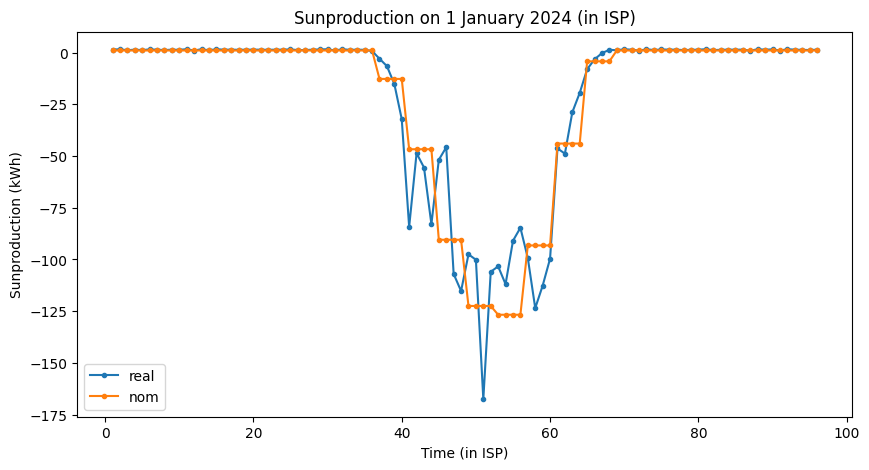

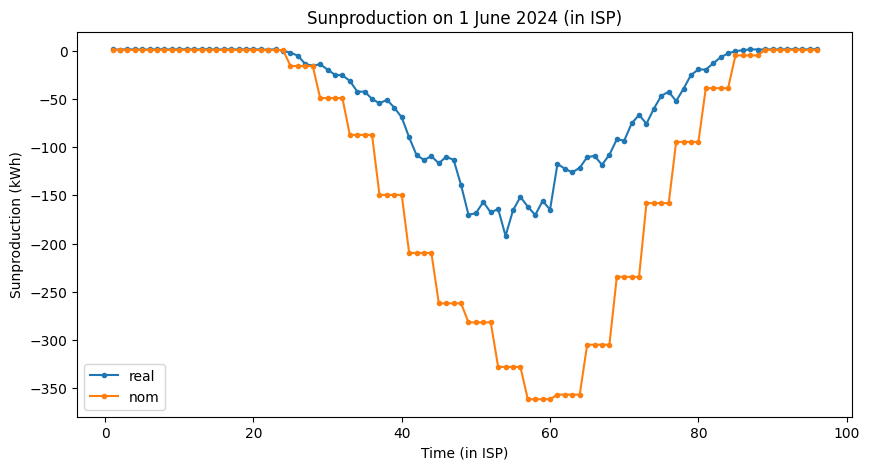

In [ ]:
# for now I just want to see January 1st and also a warmer day -> 1 June.
df_1januari = df_2024[(df_2024["maand"] == 1) & (df_2024["DagM"] == 1)]
df_1juni = df_2024[(df_2024["maand"] == 6) & (df_2024["DagM"] == 1)]

# graph: kWh_real_zon (1 January)
plt.figure(figsize=(10, 5))
plt.plot(df_1januari["ISP"], df_1januari["kWh_real_zon"], marker='.', label="real")
plt.plot(df_1januari["ISP"], df_1januari["kWh_nom_zon"], marker='.', label="nom")
plt.xlabel("Time (in ISP)")
plt.ylabel("Sunproduction (kWh)")
plt.title(f"Sunproduction on 1 {maanden[1]} 2024 (in ISP)")
plt.legend()
plt.show()

# graph: kWh_real_zon (1 June)
plt.figure(figsize=(10, 5))
plt.plot(df_1juni["ISP"], df_1juni["kWh_real_zon"], marker='.', label="real")
plt.plot(df_1juni["ISP"], df_1juni["kWh_nom_zon"], marker='.', label="nom")
plt.xlabel("Time (in ISP)")
plt.ylabel("Sunproduction (kWh)")
plt.title(f"Sunproduction on 1 {maanden[6]} 2024 (in ISP)")
plt.legend()
plt.show()

To focus on specific fluctuations, the following graph zooms in on the period of January 1, 2024 from 10:00 - 16:00 (ISP 41-64). A noticeable drop in kWh production around ISP 51 could have been that it was cloudy at first, for example, then the sun came out briefly and then back to cloudy.

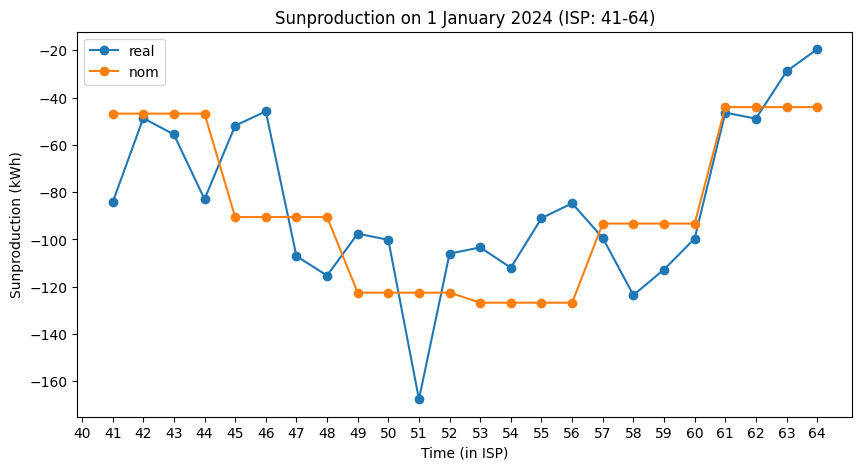

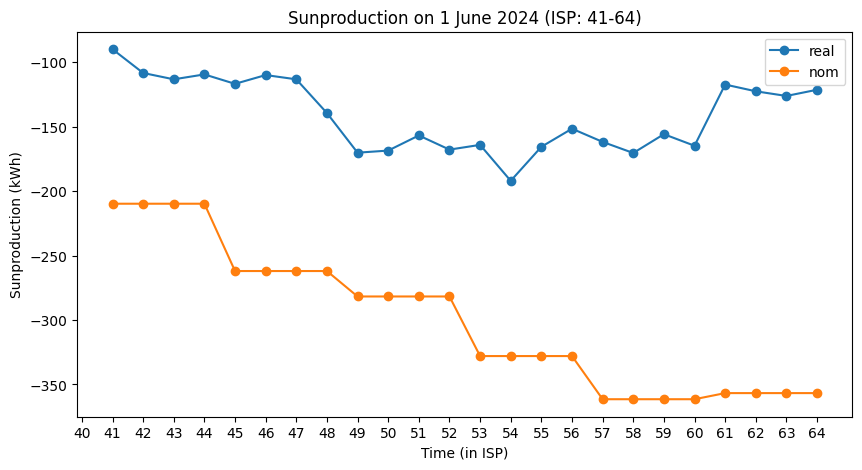

In [ ]:
# zoom in on a piece of the previous graph

# here I only want for example: ISP <41, 64>
begin, eind = 41, 64
tussentijd = (df_2024["ISP"] >= begin) & (df_2024["ISP"] <= eind)
df_ISPjanuari = df_2024[(df_2024["maand"] == 1) & (df_2024["DagM"] == 1) & tussentijd]
df_ISPjuni = df_2024[(df_2024["maand"] == 6) & (df_2024["DagM"] == 1) & tussentijd]

# graph: kWh_real_zon (1 January)
plt.figure(figsize=(10, 5))
plt.plot(df_ISPjanuari["ISP"], df_ISPjanuari["kWh_real_zon"], marker='o', label="real")
plt.plot(df_ISPjanuari["ISP"], df_ISPjanuari["kWh_nom_zon"], marker='o', label="nom")
plt.xlabel("Time (in ISP)")
plt.ylabel("Sunproduction (kWh)")
plt.title(f"Sunproduction on 1 {maanden[1]} 2024 (ISP: 41-64)")
plt.xticks(range(40, 65))
plt.legend()
plt.show()

# graph: kWh_real_zon (1 June)
plt.figure(figsize=(10, 5))
plt.plot(df_ISPjuni["ISP"], df_ISPjuni["kWh_real_zon"], marker='o', label="real")
plt.plot(df_ISPjuni["ISP"], df_ISPjuni["kWh_nom_zon"], marker='o', label="nom")
plt.xlabel("Time (in ISP)")
plt.ylabel("Sunproduction (kWh)")
plt.title(f"Sunproduction on 1 {maanden[6]} 2024 (ISP: 41-64)")
plt.xticks(range(40, 65))
plt.legend()
plt.show()

To gain more insight into the yield of the solar production of January 1 2024  and June 1, respectively, the following graph has been created. This graph shows the cumulative turnover (in euros) per ISP.

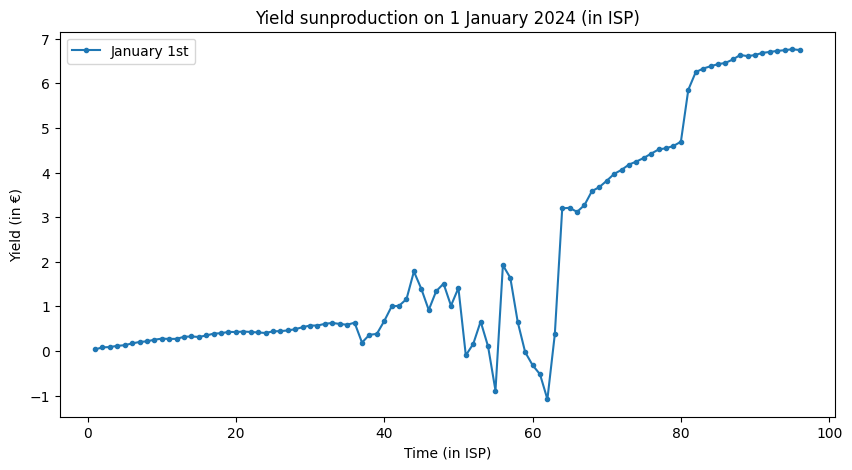

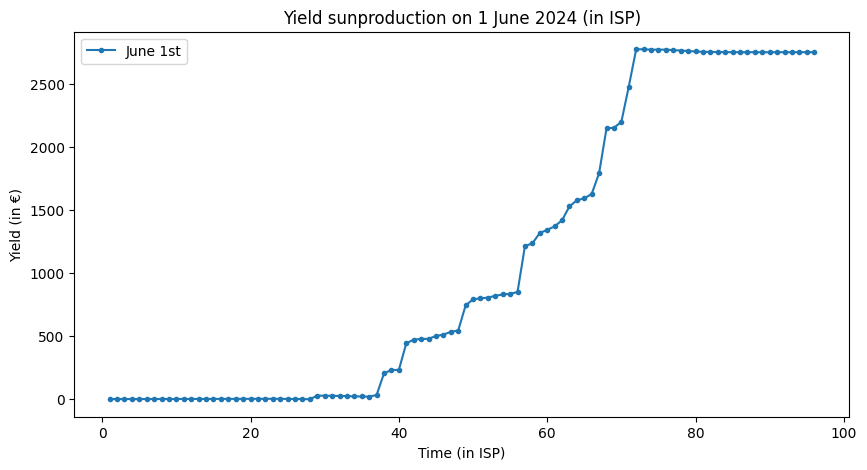

In [ ]:
# for now I just want to see January 1st and June 1st

# graph: eur_real_zon (1 jan)
plt.figure(figsize=(10, 5))
plt.plot(df_1januari["ISP"], df_1januari["eur_real_zon"].cumsum(), marker='.', label='January 1st')
plt.xlabel("Time (in ISP)")
plt.ylabel("Yield (in €)")
plt.title(f"Yield sunproduction on 1 {maanden[1]} 2024 (in ISP)")
plt.legend()
plt.show()

# graph: eur_real_zon (1 june)
plt.figure(figsize=(10, 5))
plt.plot(df_1juni["ISP"], df_1juni["eur_real_zon"].cumsum(), marker='.', label='June 1st')
plt.xlabel("Time (in ISP)")
plt.ylabel("Yield (in €)")
plt.title(f"Yield sunproduction on 1 {maanden[6]} 2024 (in ISP)")
plt.legend()
plt.show()

A graph has also been created for the yield of solar production, which is zoomed in on that day from 10:00 to 16:00.

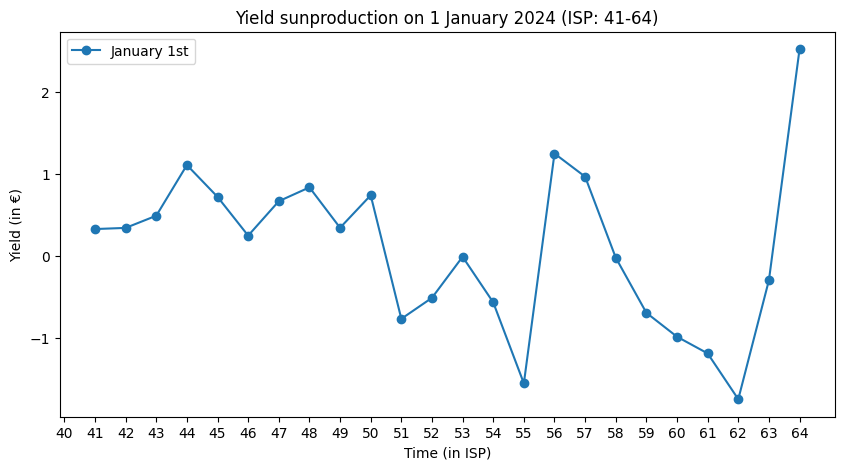

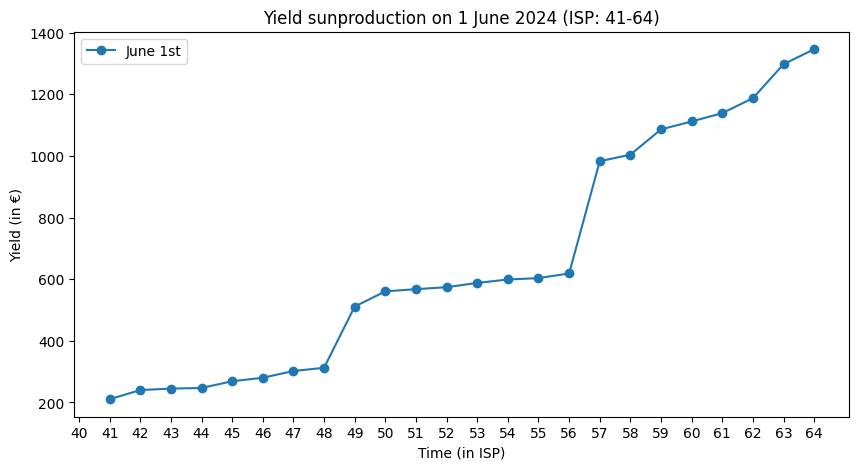

In [ ]:
# zoom in on a piece of the previous graph

# graph: eur_real_zon (1 jan)
plt.figure(figsize=(10, 5))
plt.plot(df_ISPjanuari["ISP"], df_ISPjanuari["eur_real_zon"].cumsum(), marker='o', label='January 1st')
plt.xlabel("Time (in ISP)")
plt.ylabel("Yield (in €)")
plt.title(f"Yield sunproduction on 1 {maanden[1]} 2024 (ISP: 41-64)")
plt.xticks(range(40, 65))
plt.legend()
plt.show()

# graph: eur_real_zon (1 juni)
plt.figure(figsize=(10, 5))
plt.plot(df_ISPjuni["ISP"], df_ISPjuni["eur_real_zon"].cumsum(), marker='o', label='June 1st')
plt.xlabel("Time (in ISP)")
plt.ylabel("Yield (in €)")
plt.title(f"Yield sunproduction on 1 {maanden[6]} 2024 (ISP: 41-64)")
plt.xticks(range(40, 65))
plt.legend()
plt.show()

Om te kijken of er een correlatie is tussen deze drie variabelen `eur_APX_zon`, `eur_sur_zon`, `eur_short_zon`.

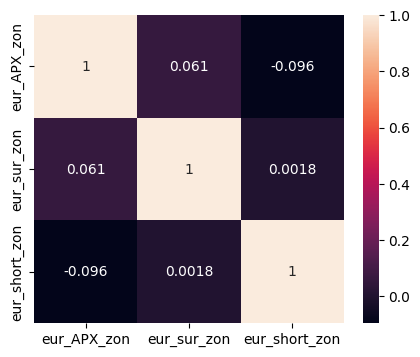

In [ ]:
corr_matrix = df_2024[['eur_APX_zon', 'eur_sur_zon', 'eur_short_zon']].corr()

plt.figure(figsize=(5,4))
sns.heatmap(corr_matrix, annot=True)
plt.show()

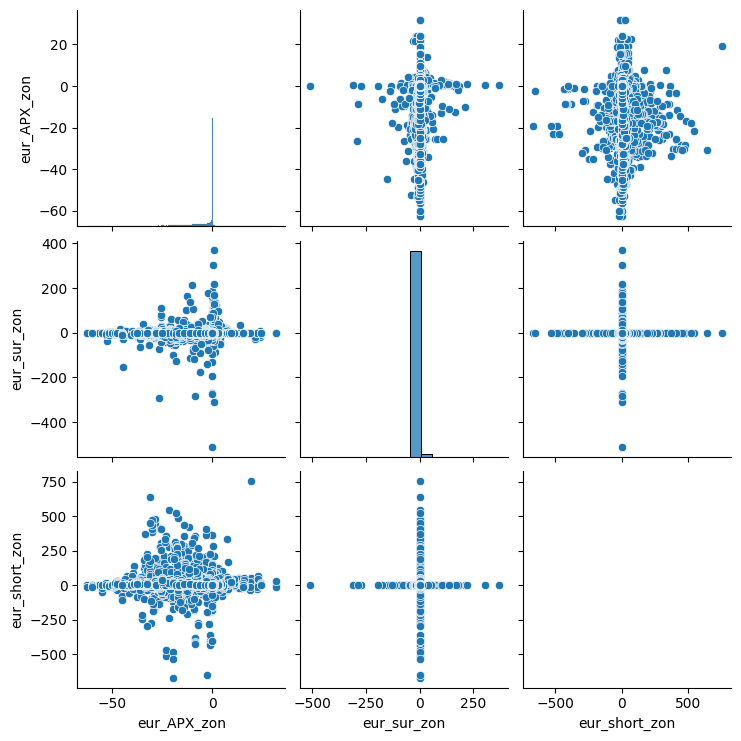

In [ ]:
sns.pairplot(df_2024[['eur_APX_zon', 'eur_sur_zon', 'eur_short_zon']])
plt.show()

## 2. The Day-ahead price of 2024
The day-ahead price dataset is integrated within the solar production dataset. These values are sourced from the [ENTSO-E Transparency Platform](https://newtransparency.entsoe.eu/market).

A time-series plot illustrates price variations throughout the day, showing fluctuations based on supply and demand conditions.

The histogram shows an example of how day-ahead prices have evolved over the course of May 1.

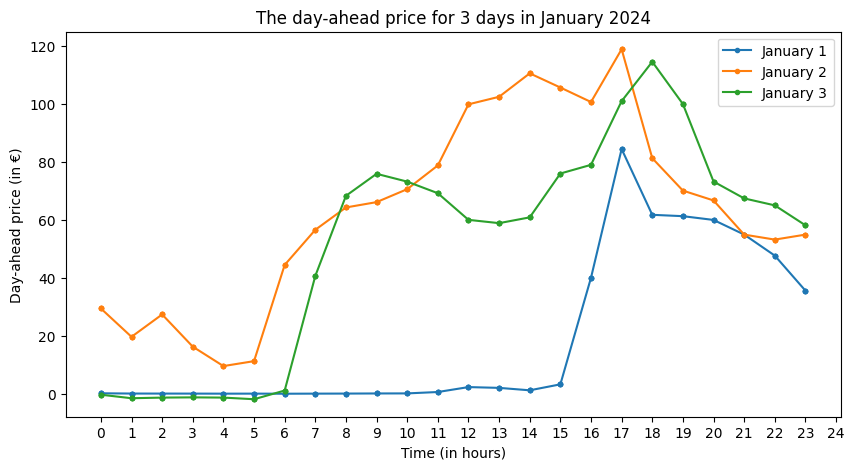

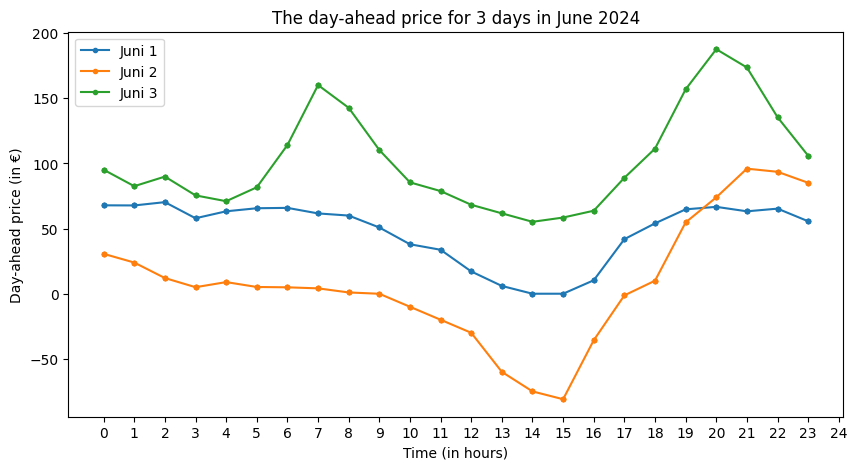

In [ ]:
# 3 days chosen to show differences
df_2januari = df_2024[(df_2024["maand"] == 1) & (df_2024["DagM"] == 2)]
df_3januari = df_2024[(df_2024["maand"] == 1) & (df_2024["DagM"] == 3)]

plt.figure(figsize=(10, 5))
plt.plot(df_1januari["Uur"], df_1januari["p_APX"], marker='.', label="January 1")
plt.plot(df_2januari["Uur"], df_2januari["p_APX"], marker='.', label="January 2")
plt.plot(df_3januari["Uur"], df_3januari["p_APX"], marker='.', label="January 3")
plt.xlabel("Time (in hours)")
plt.ylabel("Day-ahead price (in €)")
plt.title(f"The day-ahead price for 3 days in {maanden[1]} 2024")
plt.xticks(range(0, 25))
plt.legend()
plt.show()

# 3 days chosen to show differences
df_2juni = df_2024[(df_2024["maand"] == 6) & (df_2024["DagM"] == 2)]
df_3juni = df_2024[(df_2024["maand"] == 6) & (df_2024["DagM"] == 3)]

plt.figure(figsize=(10, 5))
plt.plot(df_1juni["Uur"], df_1juni["p_APX"], marker='.', label="Juni 1")
plt.plot(df_2juni["Uur"], df_2juni["p_APX"], marker='.', label="Juni 2")
plt.plot(df_3juni["Uur"], df_3juni["p_APX"], marker='.', label="Juni 3")
plt.xlabel("Time (in hours)")
plt.ylabel("Day-ahead price (in €)")
plt.title(f"The day-ahead price for 3 days in {maanden[6]} 2024")
plt.xticks(range(0, 25))
plt.legend()
plt.show()

Here is also a day where you can earn money with the day-ahead price.

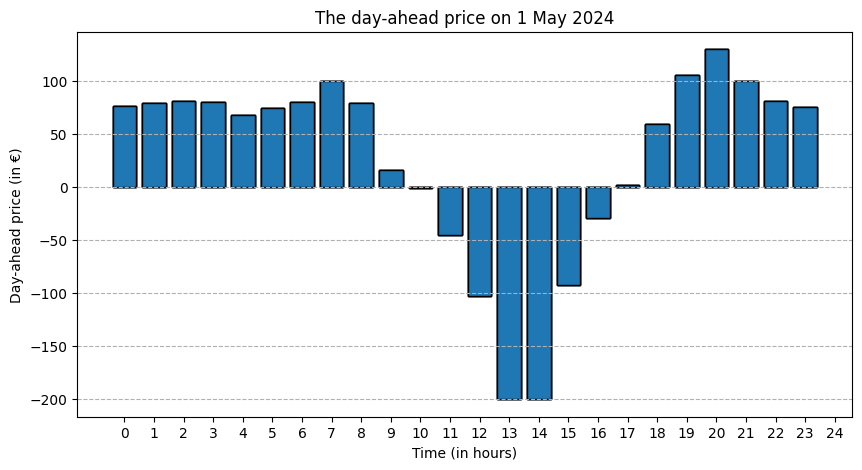

In [ ]:
# histogram
df_1mei = df_2024[(df_2024["maand"] == 5) & (df_2024["DagM"] == 1)]

plt.figure(figsize=(10, 5))
plt.bar(df_1mei["Uur"], df_1mei["p_APX"], width=0.8, edgecolor='black')
plt.xlabel("Time (in hours)")
plt.ylabel("Day-ahead price (in €)")
plt.title(f"The day-ahead price on 1 {maanden[5]} 2024")
plt.xticks(range(0, 25))
plt.grid(axis='y', linestyle='--')
plt.show()

## 3. TenneT Balance Delta of 2024
An extra dataset that maybe can be used. The Balance Delta dataset shows the energy volumes that TenneT has requested operationally via IGCC, PICASSO, aFRR and incident reserves. The values ​​in this table concern a snapshot. Important variables are:
- **Requested volumes**: requested operational balancing energy.
- **Price range**: the highest and lowest active balancing energy bids.
<!-- klopt dat?? -->

The dataset consists of the period from 01-01-2024 to 31-01-2024.

<!--
To improve usability, timestamps in the format 2024-01-01T00:00 are converted into separate month and day columns, making them easier to merge with other datasets.
 -->

In [ ]:
# all NaNs are filled with zeros
df_balance = pd.read_csv(f'{file_path}/balance_delta_202312312300_202401312300.csv', sep=';').fillna(0)

# the ISP is not well defined in the dataset, it is actually the sequence number
df_balance.rename(columns={'Isp': 'volgnummer'}, inplace=True)

# formula to still calculate the ISP
df_balance["ISP"] = np.ceil(df_balance["volgnummer"]/15).astype(int)

# add the columns for the month and day
df_balance['maand'] = pd.to_datetime(df_balance['Timeinterval Start Loc']).dt.month
df_balance['DagM'] = pd.to_datetime(df_balance['Timeinterval Start Loc']).dt.day
df_balance['jaar'] = pd.to_datetime(df_balance['Timeinterval Start Loc']).dt.year

df_balance = df_balance.drop(['Picasso Contribution Power Out', 'Picasso Contribution Power In',
                              'Timeinterval Start Loc', 'Timeinterval End Loc'],
                             axis='columns')

df_balance

,volgnummer,Power In Activated Afrr,Power Out Activated Afrr,Power In Igcc,Power Out Igcc,Power In Mfrrda,Power Out Mfrrda,Highest Upward Regulation Price,Lowest Downward Regulation Price,Mid Price,ISP,maand,DagM,jaar
0,1,0,0,0,11,0,0,0.0,0.00,26.45,1,1,1,2024
1,2,0,6,0,27,0,0,0.0,-20.86,26.45,1,1,1,2024
2,3,0,23,0,35,0,0,0.0,-35.23,26.45,1,1,1,2024
3,4,0,48,0,30,0,0,0.0,-46.72,26.45,1,1,1,2024
4,5,0,58,0,0,0,0,0.0,-46.72,26.45,1,1,1,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44635,1436,0,0,0,0,0,0,0.0,0.00,69.07,96,1,31,2024
44636,1437,0,0,6,0,0,0,0.0,0.00,69.07,96,1,31,2024
44637,1438,0,0,0,1,0,0,0.0,0.00,69.07,96,1,31,2024
44638,1439,0,0,0,1,0,0,0.0,0.00,69.07,96,1,31,2024


In [ ]:
pd.DataFrame(df_balance.dtypes.astype(str), columns=["Data Type"])

,Data Type
volgnummer,int64
Power In Activated Afrr,int64
Power Out Activated Afrr,int64
Power In Igcc,int64
Power Out Igcc,int64
Power In Mfrrda,int64
Power Out Mfrrda,int64
Highest Upward Regulation Price,float64
Lowest Downward Regulation Price,float64
Mid Price,float64


In [ ]:
df_balance.describe()

,volgnummer,Power In Activated Afrr,Power Out Activated Afrr,Power In Igcc,Power Out Igcc,Power In Mfrrda,Power Out Mfrrda,Highest Upward Regulation Price,Lowest Downward Regulation Price,Mid Price,ISP,maand,DagM,jaar
count,44640.00000,44640.000000,44640.000000,44640.000000,44640.000000,44640.0,44640.0,44640.000000,44640.000000,44640.000000,44640.00000,44640.0,44640.000000,44640.0
mean,720.50000,30.438351,33.679906,68.883468,49.984767,0.0,0.0,38.839397,13.873353,67.033024,48.50000,1.0,16.000000,2024.0
std,415.69675,68.788349,74.574205,124.532412,105.049193,0.0,0.0,134.430167,35.043374,12.267495,27.71162,0.0,8.944372,0.0
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,-312.820000,16.600000,1.00000,1.0,1.000000,2024.0
25%,360.75000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,61.170000,24.75000,1.0,8.000000,2024.0
50%,720.50000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,69.920000,48.50000,1.0,16.000000,2024.0
75%,1080.25000,17.000000,28.000000,86.000000,51.000000,0.0,0.0,76.510000,42.390000,74.980000,72.25000,1.0,24.000000,2024.0
max,1440.00000,588.000000,897.000000,817.000000,1473.000000,0.0,0.0,2499.000000,89.120000,109.050000,96.00000,1.0,31.000000,2024.0


## 4. Settlement Prices van TenneT
The Settlement Price dataset determines the prices for bids of used control capacity. These prices are determined according to the Grid Code and the documentation of the imbalance pricing system. They reflect the current energy market conditions and play a crucial role in imbalance settlement calculations.

The dataset consists of the period from 01-01-2024 to 31-01-2024.

<!--
Further analysis will explore the correlation between settlement prices, imbalance prices, and day-ahead prices, providing insights into pricing mechanisms and volatility in the Dutch energy market. -->

In [ ]:
# all NaNs are filled with zeros
df_settlement = pd.read_csv(f'{file_path}/settlement_prices_202312312300_202412312300.csv', sep=';').fillna(0)

# add the columns for the month and day
df_settlement['maand'] = pd.to_datetime(df_settlement['Timeinterval Start Loc']).dt.month
df_settlement['DagM'] = pd.to_datetime(df_settlement['Timeinterval Start Loc']).dt.day
df_settlement['jaar'] = pd.to_datetime(df_settlement['Timeinterval Start Loc']).dt.year

df_settlement = df_settlement.drop(['Timeinterval Start Loc', 'Timeinterval End Loc'], axis='columns')

df_settlement

,Isp,Currency Unit Name,Price Measurement Unit Name,Incident Reserve Up,Incident Reserve Down,Price Dispatch Up,Price Dispatch Down,Price Shortage,Price Surplus,Regulation State,Regulating Condition,maand,DagM,jaar
0,1,EUR,MWh,NO,NO,83.22,-46.72,83.22,-46.72,2,UP_AND_DOWN,1,1,2024
1,2,EUR,MWh,NO,NO,76.91,0.00,76.91,76.91,1,UP,1,1,2024
2,3,EUR,MWh,NO,NO,66.91,0.00,66.91,66.91,1,UP,1,1,2024
3,4,EUR,MWh,NO,NO,66.91,0.00,66.91,66.91,1,UP,1,1,2024
4,5,EUR,MWh,NO,NO,81.13,0.00,81.13,81.13,1,UP,1,1,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35131,92,EUR,MWh,NO,NO,99.37,-16.76,99.37,-16.76,2,UP_AND_DOWN,12,31,2024
35132,93,EUR,MWh,NO,NO,121.00,0.00,121.00,121.00,1,UP,12,31,2024
35133,94,EUR,MWh,NO,NO,113.01,0.00,113.01,113.01,1,UP,12,31,2024
35134,95,EUR,MWh,NO,NO,107.07,0.00,107.07,107.07,1,UP,12,31,2024


In [ ]:
pd.DataFrame(df_settlement.dtypes.astype(str), columns=["Data Type"])

,Data Type
Isp,int64
Currency Unit Name,object
Price Measurement Unit Name,object
Incident Reserve Up,object
Incident Reserve Down,object
Price Dispatch Up,float64
Price Dispatch Down,float64
Price Shortage,float64
Price Surplus,float64
Regulation State,int64


In [ ]:
df_settlement.describe()

,Isp,Price Dispatch Up,Price Dispatch Down,Price Shortage,Price Surplus,Regulation State,maand,DagM,jaar
count,35136.000000,35136.000000,35136.000000,35136.000000,35136.000000,35136.000000,35136.000000,35136.000000,35136.0
mean,48.500455,95.319614,0.596837,96.215638,66.178940,0.254810,6.514458,15.756375,2024.0
std,27.712492,235.886444,102.977864,241.141550,225.947764,1.175986,3.451280,8.810971,0.0
min,1.000000,0.000000,-1861.690000,-1593.100000,-1861.690000,-1.000000,1.000000,1.000000,2024.0
25%,24.750000,0.000000,-4.000000,44.467500,0.000000,-1.000000,4.000000,8.000000,2024.0
50%,48.500000,71.555000,0.000000,76.050000,65.100000,1.000000,7.000000,16.000000,2024.0
75%,72.250000,103.000000,50.490000,100.735000,89.212500,1.000000,10.000000,23.000000,2024.0
max,100.000000,2888.000000,241.500000,2888.000000,2888.000000,2.000000,12.000000,31.000000,2024.0
